In [1]:
import numpy as np
import path as Path
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.cosmology import FlatwCDM
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import LambdaCDM
from astropy.cosmology import wCDM
from astropy.cosmology import Flatw0waCDM
import scipy
from escape_functions import *
from multiprocessing import Process
from multiprocessing import Queue
from multiprocessing import Pool
import emcee
import corner

In [2]:
cosmo = FlatwCDM(H0=70, Om0=0.2,w0=-1)
cosmo = wCDM(H0=70, Om0=0.2,Ode0 = 0.8,w0=-1)
cosmo = FlatLambdaCDM(H0=70,Om0=0.2)
cosmo = LambdaCDM(H0=70, Om0=0.2, Ode0 = 0)
cosmo = Flatw0waCDM(H0=70, Om0=0.2, w0=-0.9, wa=0.2)

In [3]:
z=0.2
M200 = 1e15*u.solMass
rho_crit = cosmo.critical_density(z)
rho_crit = rho_crit.to(u.solMass / u.Mpc**3)
cosmo = FlatLambdaCDM(H0=70,Om0=0.2,name='FlatLambdaCDM')
R200crit =  (3*M200/(4*np.pi*200.* rho_crit))**(1./3.)
radius_array = np.linspace(0.3,2.0,100).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
theta_array = radius_array /cosmo.angular_diameter_distance(z)
R200crit =  (3*M200/(4*np.pi*200.* rho_crit))**(1./3.)
print R200crit
print astroc.G.to( u.Mpc *  u.km**2 / u.s**2 / u.solMass)

1.94194203988 Mpc
4.30091727007e-09 km2 Mpc / (s2 solMass)


In [4]:
M200 = 1e15*u.solMass
cosmo = FlatLambdaCDM(H0=70,Om0=0.2,name = 'FlatLambdaCDM')
radius_array = np.linspace(0.3,2.0,100).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
z = 0.2
theta_array = radius_array /cosmo.angular_diameter_distance(z)
M200,R200,conc,rho_0,h,n, simga_rho_0, sigma_h, sigma_n =  einasto_nfwM200_errors(M200, 1/20.0, z,cosmo)
print rho_0, h,n

3.51323424909618e+17 0.00015851545071770797 3.9924039489419973


In [5]:
r,phi0 = v_esc_einasto(theta_array,z,rho_0,h,n,100,cosmo)
Mtot = M_total(rho_0, h, n)
req = r_eq(z,Mtot,cosmo)
print req
Mtot = M_total(rho_0, h, n)
H_z = cosmo.H(z)
G_newton = astroc.G.to( u.Mpc *  u.km**2 / u.s**2 / u.solMass).value #Mpc km2/s^2 Msol
r_eq_cubed = -((G_newton*Mtot) / (q_z_function(z, cosmo) * H_z.value**2.))
req = (r_eq_cubed)**(1.0/3.0)# Mpc
print req
#print np.sqrt(2.*phi_einasto(req,rho_2,r_2,alpha))


15.480040435062712
15.480040435062712


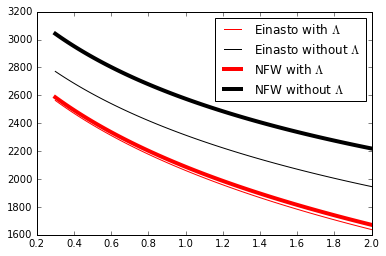

In [12]:
z=0.2
cosmo = FlatLambdaCDM(H0=70,Om0=0.2,name = 'FlatLambdaCDM')
theta_array = radius_array /cosmo.angular_diameter_distance(z)
r,phi0 = v_esc_einasto(theta_array,z,rho_0,h,n,100,cosmo)
cosmo = LambdaCDM(H0=70,Om0=0.2,Ode0 = 0,name = 'LambdaCDM')
theta_array = radius_array /cosmo.angular_diameter_distance(z)
r,phi1 = v_esc_einasto(theta_array,z,rho_0,h,n,100,cosmo)
plt.plot(r,phi0,'r-', label ='Einasto with $\Lambda$')
plt.plot(r,phi1,'k-', label = 'Einasto without $\Lambda$')

cosmo = FlatLambdaCDM(H0=70,Om0=0.2,name = 'FlatLambdaCDM')
theta_array = radius_array /cosmo.angular_diameter_distance(z)
r,phi0 = v_esc_NFW_M200(theta_array,z,M200,100,cosmo)
cosmo = LambdaCDM(H0=70,Om0=0.2,Ode0 = 0,name = 'LambdaCDM')
theta_array = radius_array /cosmo.angular_diameter_distance(z)
r,phi1 = v_esc_NFW_M200(theta_array,z,M200,100,cosmo)
plt.plot(r,phi0,'r', lw=4,label ='NFW with $\Lambda$')
plt.plot(r,phi1,'k', lw=4,label = 'NFW without $\Lambda$')
plt.legend()
plt.show()


In [13]:
M200_fid = 1e15*u.solMass
cosmo = wCDM(H0=70, Om0=0.2,Ode0 = 0.8,w0=-1,name = 'wCDM')
radius_array = np.linspace(0.3,2.0,100).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
z = 0.2
theta_array = radius_array /cosmo.angular_diameter_distance(z)
real_error = []
real_mean = []
corr_coef = 0.2
for i in range(16):
    M200,R200,conc,rho_0, h, n, sigma_rho_0, sigma_h,sigma_n =  einasto_nfwM200_errors(M200_fid, np.float(i)/20.0, z,cosmo)
    M200_einasto = 4*np.pi*integrate.quad(rho_einasto_int,0,R200.value,args=(rho_0,h,n))[0]
    M200_einasto_p = 4*np.pi*integrate.quad(rho_einasto_int,0,R200.value,args=(rho_0+sigma_rho_0, h+corr_coef*sigma_h, n+sigma_n))[0]
    M200_einasto_m = 4*np.pi*integrate.quad(rho_einasto_int,0,R200.value,args=(rho_0-sigma_rho_0, h-corr_coef*sigma_h, n-sigma_n))[0]
    real_error =  np.append(real_error,((1-M200_einasto_m) + (M200_einasto_p-1))/(2*M200_einasto))
    real_mean =  np.append(real_mean,M200_einasto)
plt.plot(np.arange(0,0.8,0.05),real_error,'o')
plt.plot([0,1],[0,1])
plt.xlabel('Input M$_{200}$ Error')
plt.ylabel('Einasto Fitted M$_{200}$ Error')
#Note the 0.7, which is given in Alejo's paper's appendix. We need it!
print 'Mean fit (1e15) = ', np.sum(real_mean)/16/1e15

M200,R200,conc,rho_0, h,n, sigma_rho_0, sigma_h,sigma_n =  einasto_nfwM200_errors(M200_fid, 0.2, z,cosmo)
print 'M200 = ', M200
print 'R200 (sphere) = ', R200
print 'Conc (Sereno) = ', conc
print 'n = ',n
print 'sigma n = ', sigma_n
print 'rho_0 = ',rho_0
print 'sigma_rho_0 = ', sigma_rho_0
print 'h = ', h
print 'sigma_h = ', corr_coef*h

Mean fit (1e15) =  0.9982395187299129
M200 =  1e+15 solMass
R200 (sphere) =  1.97141172229 Mpc
Conc (Sereno) =  3.2041969809
n =  3.9924039489419973
sigma n =  0.035425934782328916
rho_0 =  3.51323424909618e+17
sigma_rho_0 =  5009503975473920.0
h =  0.00015851545071770797
sigma_h =  3.1703090143541596e-05


In [14]:
cosmo = wCDM(H0=70, Om0=0.2,Ode0 = 0.8,w0=-1,name = 'wCDM')
radius_array = np.linspace(0.3,2.0,100).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
z = 0.2
theta_array = radius_array /cosmo.angular_diameter_distance(z)
real_error = []
real_mean = []
corr_coef = 0.85
for i in range(16):
    M200,R200,conc,rho_s, sigma_rho_s,r_s, sigma_r_s =  nfws_errors(M200, np.float(i)/20.0, z,cosmo)
    M200_nfws = 4*np.pi*integrate.quad(rhos_nfw_int,0,R200.value,args=(rho_s, r_s))[0]
    M200_nfws_p = 4*np.pi*integrate.quad(rhos_nfw_int,0,R200.value,args=(rho_s+sigma_rho_s,r_s+corr_coef*sigma_r_s))[0]
    M200_nfws_m = 4*np.pi*integrate.quad(rhos_nfw_int,0,R200.value,args=(rho_s-sigma_rho_s,r_s-corr_coef*sigma_r_s))[0]
    real_error =  np.append(real_error,((1-M200_nfws_m) + (M200_nfws_p-1))/(2*M200_nfws))
    real_mean =  np.append(real_mean,M200_nfws)
plt.plot(np.arange(0,0.8,0.05),real_error,'o')
plt.plot([0,1],[0,1])
plt.xlabel('Input M$_{200}$ Error')
plt.ylabel('NFW Fitted M$_{200}$ Error')
#Note the 0.7, which is given in Alejo's paper's appendix. We need it!
print 'Mean fit (1e15) = ', np.sum(real_mean)/16/1e15

M200,R200,conc,rho_s, sigma_rho_s,r_s, sigma_r_s  =  nfws_errors(M200, 0.2, z,cosmo)

print 'M200 = ', M200
print 'R200 (sphere) = ', R200
print 'Conc (Sereno) = ', conc
print 'rho_s = ' , rho_s
print 'sigma rho_s = ' , sigma_rho_s
print 'r_s = ',r_s
print 'sigma r_s = ', corr_coef*sigma_r_s

Mean fit (1e15) =  1.0000000000000004
M200 =  1e+15 solMass
R200 (sphere) =  1.97141172229 Mpc
Conc (Sereno) =  3.2041969809
rho_s =  506983663890014.3
sigma rho_s =  21823703315230.688
r_s =  0.6152592159732078
sigma r_s =  0.043473693512688094


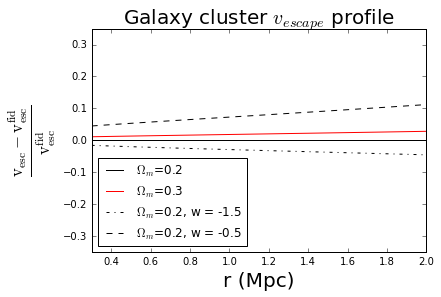

At z =  0.2


In [15]:
M200 = 1e15
cosmo = FlatLambdaCDM(H0=70,Om0=0.2,name = 'FlatLambdaCDM')
radius_array = np.linspace(0.3,2.0,100).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
z = 0.2
theta_array = radius_array /cosmo.angular_diameter_distance(z)
r,phi0 = v_esc_einasto(theta_array,z,rho_0,h,n,100,cosmo)
plt.plot(radius_array,(phi0-phi0)/phi0*1.0,'k',label=r'$\Omega_m$=0.2')
cosmo = FlatLambdaCDM(H0=70,Om0=0.3,name = 'FlatLambdaCDM')
r,phi = v_esc_einasto(theta_array,z,rho_0,h,n,100,cosmo)
plt.plot(radius_array,(phi-phi0)/phi0*1.0,'r', label=r'$\Omega_m$=0.3')
cosmo = FlatwCDM(H0=70,Om0=0.2,w0=-1.5,name = 'FlatwCDM')
r,phi = v_esc_einasto(theta_array,z,rho_0,h,n,100,cosmo)
plt.plot(radius_array,(phi-phi0)/phi0*1.0,'k-.',label=r'$\Omega_m$=0.2, w = -1.5')
cosmo = FlatwCDM(H0=70,Om0=0.2,w0=-0.5,name = 'FlatwCDM')
r,phi = v_esc_einasto(theta_array,z,rho_0,h,n,100,cosmo)
plt.plot(radius_array,(phi-phi0)/phi0*1.0,'k--',label=r'$\Omega_m$=0.2, w = -0.5')
plt.legend(loc=0)
plt.xlim(0.3,2)
plt.ylim(-0.35,0.35)
plt.ylabel(r'$\frac{\rm{v}_{esc}-\rm{v}_{esc}^{fid}}{\rm{v}_{esc}^{fid}}$',fontsize=24)
plt.xlabel('r (Mpc)', fontsize=20)
plt.title(r'Galaxy cluster $v_{escape}$ profile',fontsize=20)
plt.show()
print 'At z = ', z

In [16]:
cosmo = FlatLambdaCDM(H0=70,Om0=0.2,name = 'FlatLambdaCDM')
z = 0.2
z= np.arange(0.01, 0.8, 0.01)
rrr = 1.5
vesc_z0 = []
radius_use = 35
for i in range(len(z)):
    theta_array = radius_array /cosmo.angular_diameter_distance(z[i])
    r,vesc = v_esc_einasto(theta_array,z[i],rho_0,h,n,100,cosmo)
    vesc_z0 = np.append(vesc_z0,vesc[radius_use])
plt.plot(z,(vesc_z0-vesc_z0)/vesc_z0*1.0,'k',label=r'$\Omega_m$=0.2')
cosmo = FlatLambdaCDM(H0=70,Om0=0.3,name = 'FlatLambdaCDM')
vesc_z = []
for i in range(len(z)):
    theta_array = radius_array /cosmo.angular_diameter_distance(z[i])
    r,vesc = v_esc_einasto(theta_array,z[i],rho_0,h,n,100,cosmo)
    vesc_z = np.append(vesc_z,vesc[radius_use])
plt.plot(z,(vesc_z-vesc_z0)/vesc_z0*1.0,'r', label=r'$\Omega_m$=0.3')
vesc_z = []
cosmo = FlatwCDM(H0=70,Om0=0.2,w0=-1.5,name = 'FlatwCDM')
for i in range(len(z)):
    theta_array = radius_array /cosmo.angular_diameter_distance(z[i])
    r,vesc = v_esc_einasto(theta_array,z[i],rho_0,h,n,100,cosmo)
    vesc_z = np.append(vesc_z,vesc[radius_use])
plt.plot(z,(vesc_z-vesc_z0)/vesc_z0*1.0,'k-.',label=r'$\Omega_m$=0.2, w = -1.5')
vesc_z = []
cosmo = FlatwCDM(H0=70,Om0=0.2,w0=-0.5,name = 'FlatwCDM')
for i in range(len(z)):
    theta_array = radius_array /cosmo.angular_diameter_distance(z[i])
    r,vesc = v_esc_einasto(theta_array,z[i],rho_0,h,n,100,cosmo)
    vesc_z = np.append(vesc_z,vesc[radius_use])
plt.plot(z,(vesc_z-vesc_z0)/vesc_z0*1.0,'k--',label=r'$\Omega_m$=0.2, w = -0.5')
plt.legend(loc=0)
plt.xlim(0,0.8)
plt.ylim(-0.35,0.35)
plt.ylabel(r'$\frac{\rm{v}_{esc}-\rm{v}_{esc}^{fid}}{\rm{v}_{esc}^{fid}}$',fontsize=24)
plt.xlabel('redshift z', fontsize=20)
plt.title(r'Galaxy cluster $v_{escape}$ evolution',fontsize=20)
plt.show()
print 'At r = ',r[radius_use]


At r =  0.901


[0.00043418 0.00070771 0.00098124 0.00125477 0.0015283  0.00180038
 0.00207391 0.00234744 0.00262097 0.0028945 ]
[2548.06739722 2479.04540181 2056.09456622 2219.57721483 1830.66445057
 2005.88893841 1697.93343949 1759.84701907 1530.05244244 1501.2325715 ]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


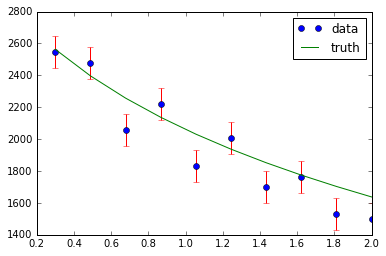

In [18]:
radial_bins = 10
error_kms = 100
cosmo = wCDM(H0=70, Om0=0.2,Ode0 = 0.8,w0=-1,name = 'wCDM')
radius_array = np.linspace(0.3,2.0,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
z = 0.2
theta_data_array = radius_array /cosmo.angular_diameter_distance(z)
xdata = theta_data_array.value
#d_alpha = np.random.normal(alpha,sigma_alpha)
#d_r_2 = np.random.normal(r_2,sigma_r_2)
#d_rho_2 = np.random.normal(rho_2*1e14,sigma_rho_2)/1e14
r,ydata = v_esc_einasto(theta_data_array,z,rho_0,h,n,100,cosmo) + np.random.normal(0,error_kms,size=radial_bins) 
ydata_err = np.zeros(len(ydata)) + error_kms
print xdata
print ydata
print ydata_err
r,truth = v_esc_einasto(theta_data_array,z,rho_0,h,n,100,cosmo)
plt.plot(r,ydata, 'o', linestyle='None',label = 'data')
plt.plot(r, truth, '-', label = 'truth')
plt.legend()
plt.errorbar(r,ydata,yerr=ydata_err, linestyle='None')
plt.show()